### Next sample strategy

Considered strategies used to propose the next problem:
1. Randomly sample from the dataset D. Does not model the student and is therefore unable to adapt to their ability. May present redundant teaching examples of concepts that have already been learned by the student and not reinforce concepts that the student has shown to be uncertain about.
2. ~~Worst predicted. Related to uncertainty sampling used in Active Learning. Selects the next teaching image whose prediction deviates most from the ground truth. Prone to proposing outliers. In the learning to program problem, maybe it presents the hardest exercises?~~
3. Expected Error Reduction. Chooses the teaching image which, if labeled correctly, would have the greatest reduction on the future error over the images that are not in the teaching set. Student’s conditional distribution given the teaching set can be approximated using Gaussian Random Field.

#### Import libraries

In [1]:
# Input
from db import PythonProblems
import io

# Helpers
import numpy as np

# Preprocessing
import tokenize
from sklearn.feature_extraction.text import CountVectorizer

# Distance
# from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import cosine_similarity

# Learning
from clustering import Clustering
from plot2d import Plot2D
from sampling import get_next_sample

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from generate_pdf import PDFReport

%matplotlib inline

In [2]:
db = PythonProblems('python.sqlite')

In [3]:
removed_itens = ['NEWLINE', 'STRING', 'ENDMARKER', 'NUMBER', 'INDENT', 'DEDENT', "NL", 'COMMENT', 'ERRORTOKEN']
allowed_itens = ['NAME', 'OP']
cursor = db.conn.cursor()
docs = []
docs_id = []
doc_category = []
errors = []
questions = []
solutions = []

# lendo os dados
cursor.execute("""
SELECT solution.id, solution.content, problem.content, problem.category FROM solution, problem where solution.problem_id = problem.id;
""")


for idx, row in enumerate(cursor.fetchall()):
    file = io.StringIO(row[1])
    doc = []
    try:
        for item in tokenize.generate_tokens(file.readline):
            if tokenize.tok_name[item[0]] not in removed_itens:
                if tokenize.tok_name[item[0]] in allowed_itens:
                    doc.append(item[1])
                else:
                    print("%s %s" % (tokenize.tok_name[item[0]], item[1]))
    except (IndentationError, tokenize.TokenError):
        errors.append("Please, fix solution %d before continuing" % (idx+1))
    
    if doc == []:
        continue
    docs.append(' '.join(doc))
    docs_id.append(row[0])
    doc_category.append(row[-1])
    questions.append(row[2])
    solutions.append(row[1])

print("Got %d documents" %(idx+1))

if not errors:
    print("Success in parsing all documents! You may go on!")
else:
    for item in errors:
        print(item)

Got 758 documents
Success in parsing all documents! You may go on!


***Limitação do parser: variável e nome reservado são do mesmo tipo. Não consigo separar sem fazer uma pré-lista. Mas pode ser o critério para ajustar o CountVectorizer***

### Preprocessing solutions into bag of words ###

In [4]:
# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
#                              stop_words = ['print'],   \
                             #max_features = 26d,
                             binary=False,
                             min_df=0.1
                            ) 

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.

train_data_features = vectorizer.fit_transform(docs)

# Numpy arrays are easy to work with, so convert the result to an 
# array
# Document-term matrix
train_data_features = train_data_features.toarray()
train_data_features.shape

(753, 16)

In [5]:
# Remove rows containing only zeros (weird exercises)
solution_sample = train_data_features[~(train_data_features==0).all(1)]
docs_id = np.asarray(docs_id)[~(train_data_features==0).all(1)]
doc_category = np.asarray(doc_category)[~(train_data_features==0).all(1)]
questions = np.asarray(questions)[~(train_data_features==0).all(1)]
solution_sample.shape

(750, 16)

### Cluster solutions

In [6]:
%%time
cluster_names = ['', 'conditional', 'dict', 'file', 'function', 'list', 'loop'] #'math', 'string']
handler = Plot2D(clusters=cluster_names, doc_category=doc_category, doc_id=docs_id)
handler.seed = 1
handler.reduce(solution_sample)

CPU times: user 15.6 s, sys: 776 ms, total: 16.3 s
Wall time: 16.2 s


### Selecting observations

In [7]:
import pandas as pd

In [8]:
data = pd.DataFrame(handler.X)

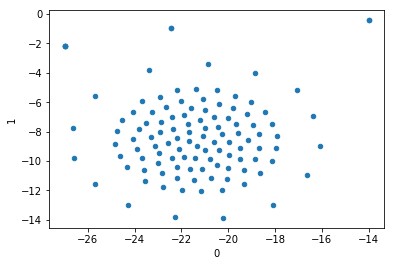

In [9]:
cluster1 = data[(data[0] < -14) & (data[1]<0)]
cluster1.plot.scatter(0,1)

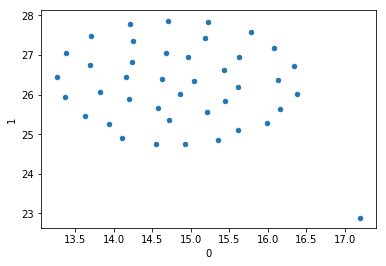

In [10]:
cluster2 = data[(data[0] > 12) & (data[1] > 20)]
cluster2.plot.scatter(0,1)

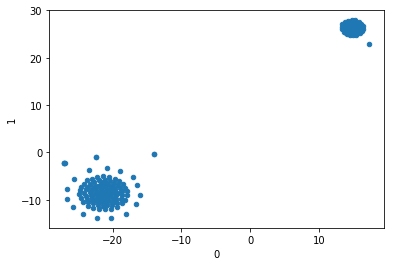

In [11]:
data_clean = pd.concat([cluster1, cluster2])
data_clean.plot.scatter(0,1)

3447912903


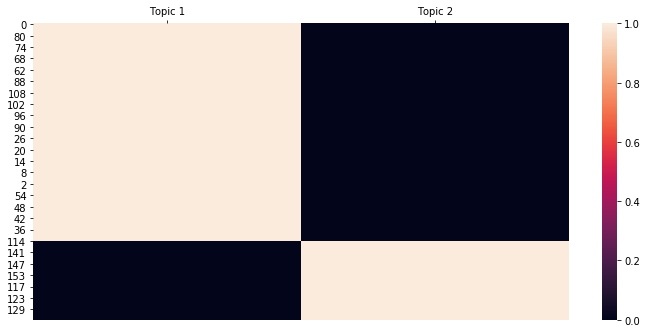

In [12]:
clustering = Clustering(data_clean, 2)
# clustering.seed = 4006033762
# clustering.seed = 0
clustering._generate_random_state()
model, document_topic, word_topic = clustering.gaussian_mixture()
print(clustering.seed)
clustering.plot_topic_distribution()

In [13]:
# Create X as an empty belief state (X is the machine's model of the student's distribution)
X = np.zeros(clustering.document_topic.shape) # nS x nC
print(X.shape)

# Create Y as a document_topic matrix. For the first version, each document belongs to one topic
Y = clustering.document_topic # nS x nC
print(Y.shape)

# Create W as a similarity matrix
W = cosine_similarity(clustering.X) # nS x nS
print(W.shape)

# Set L as an unlabelled set
L = []

(156, 2)
(156, 2)
(156, 156)


In [14]:
handler = Plot2D(clusters=cluster_names, doc_category=doc_category[clustering.X.index.tolist()],
                 doc_id=docs_id[clustering.X.index.tolist()])

In [15]:
handler.X = np.array(clustering.X)
handler.xs, handler.ys = np.array(clustering.X[0]), np.array(clustering.X[1])

Question 85
Question 121
Question 1
Question 138
Question 133
Question 2
Question 146
Question 110
Question 142
Question 123
Question 40
Question 119
Question 48
Question 122
Question 128
Question 46
Question 154
Question 64
Question 145
Question 35


/home/lmoraes/miniconda3/envs/machine_teaching/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Question 136
Question 149
Question 19
Question 126
Question 109


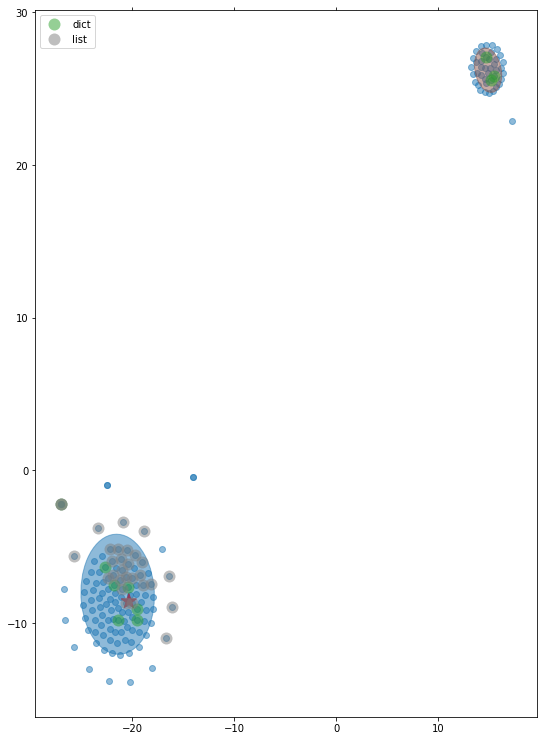

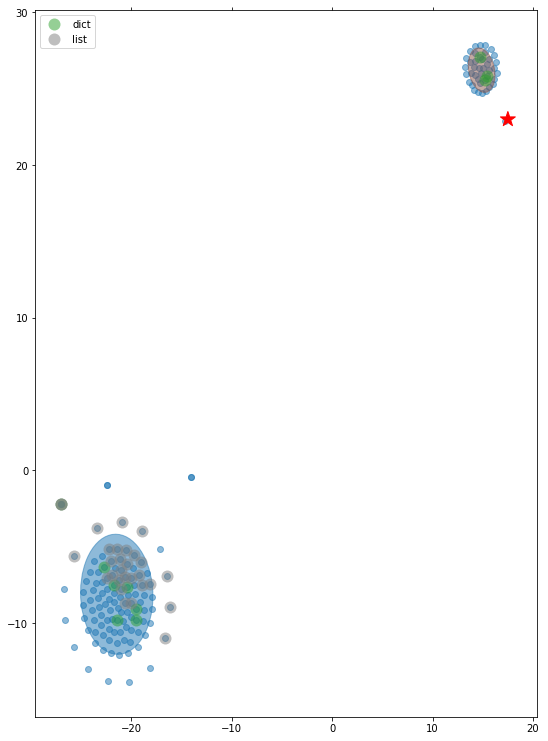

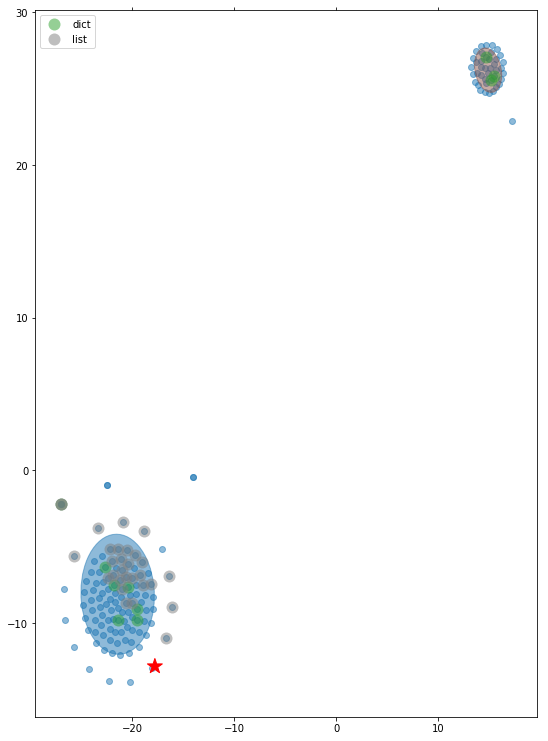

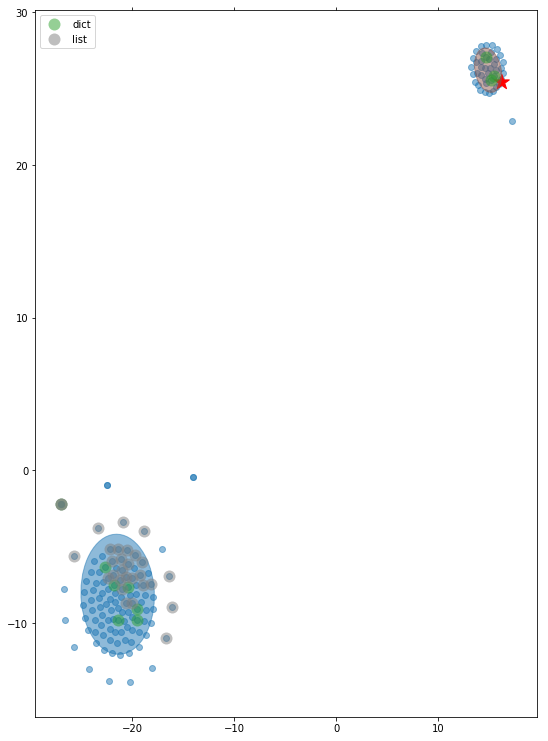

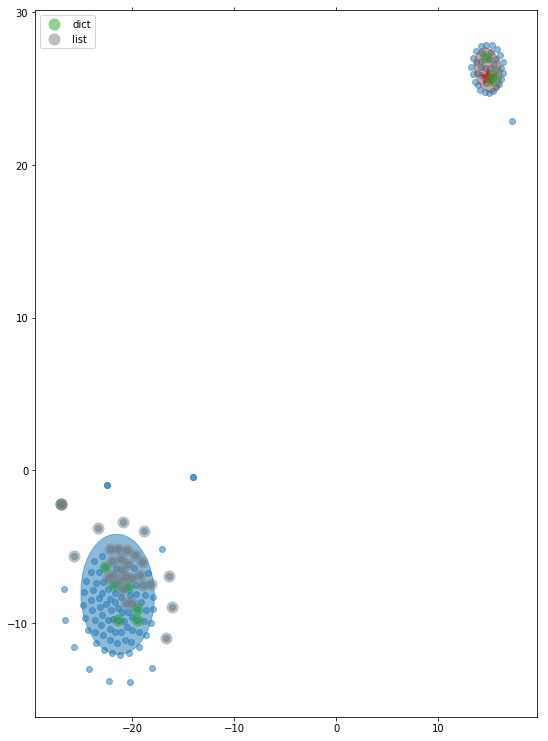

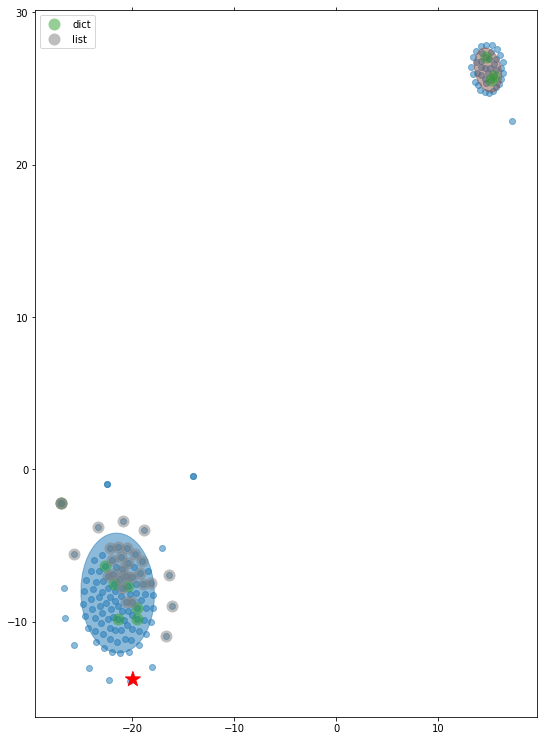

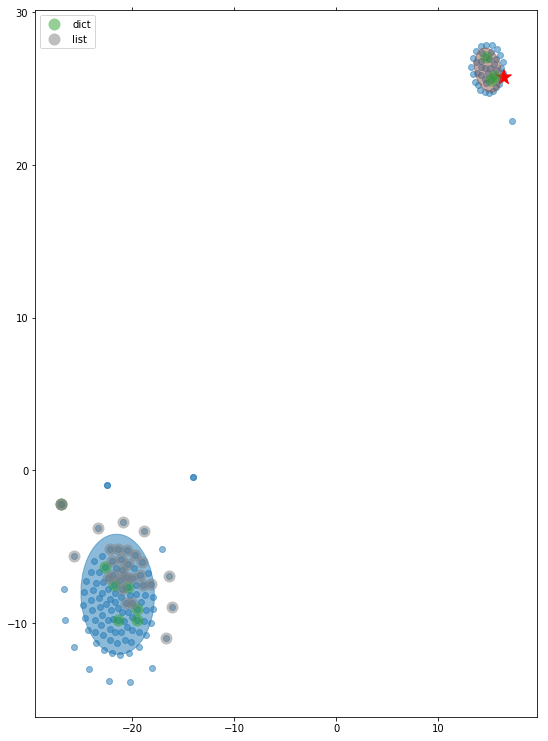

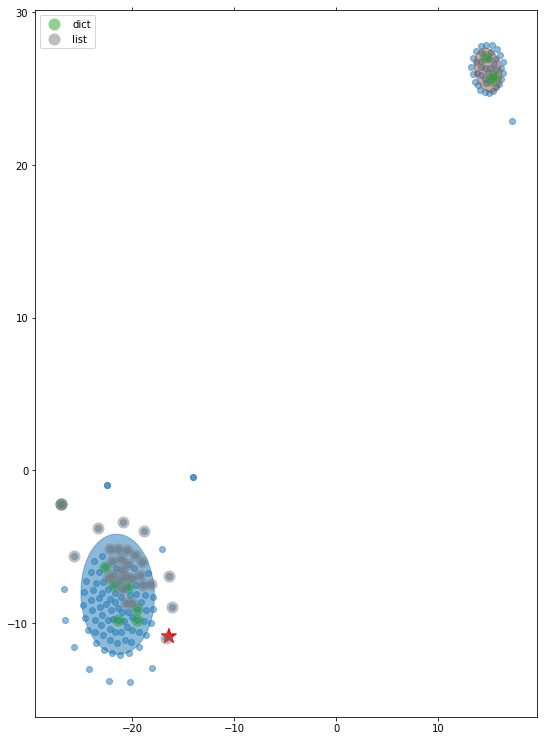

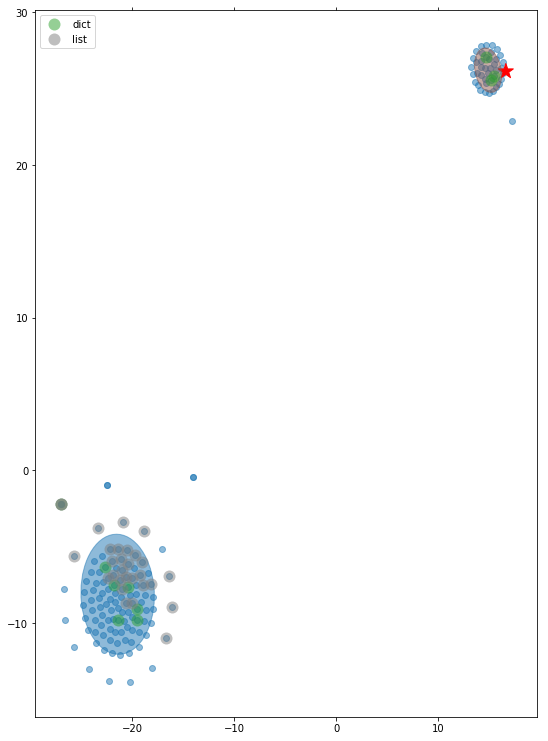

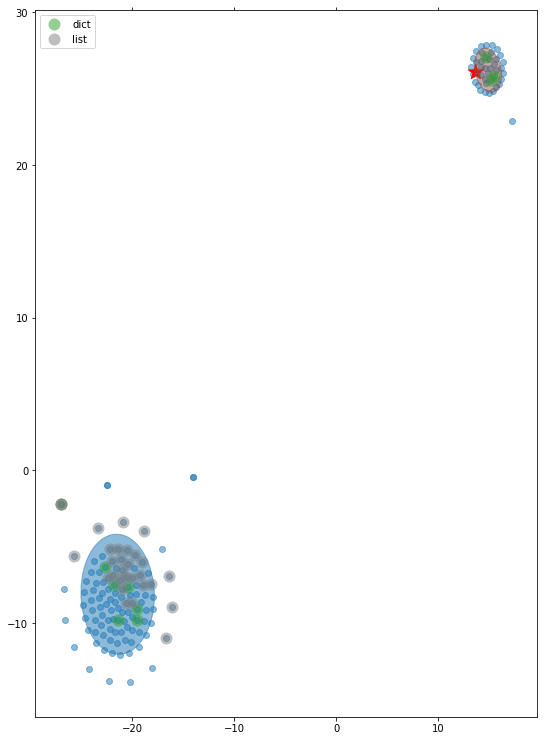

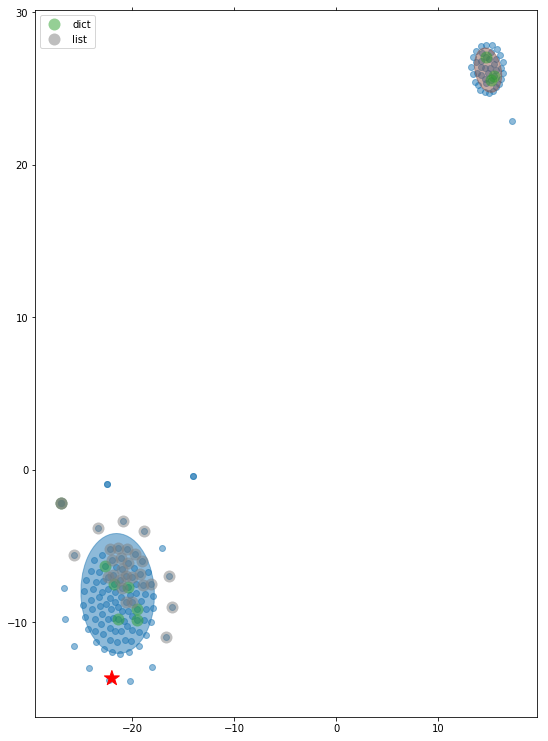

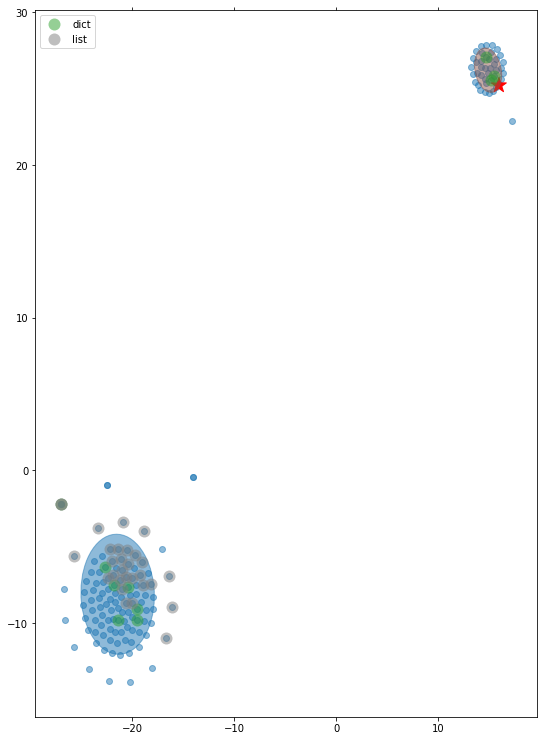

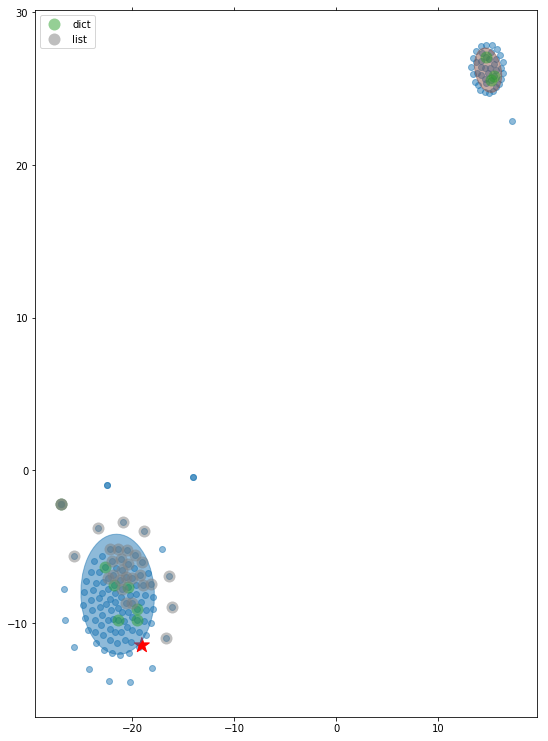

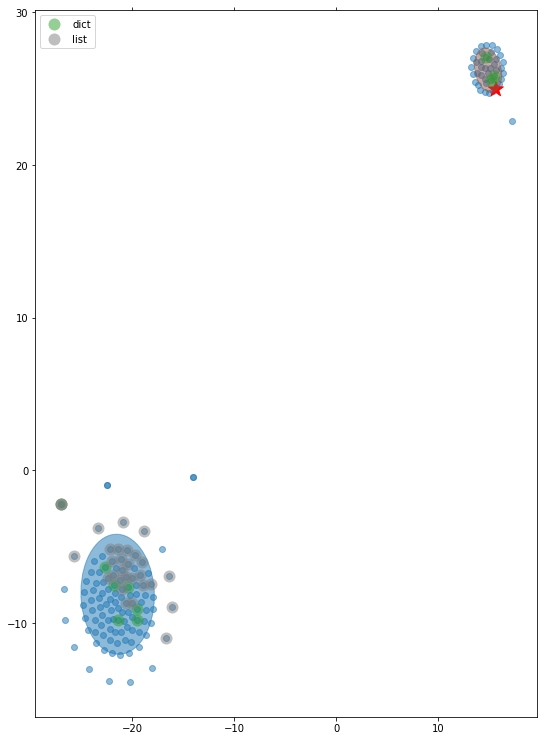

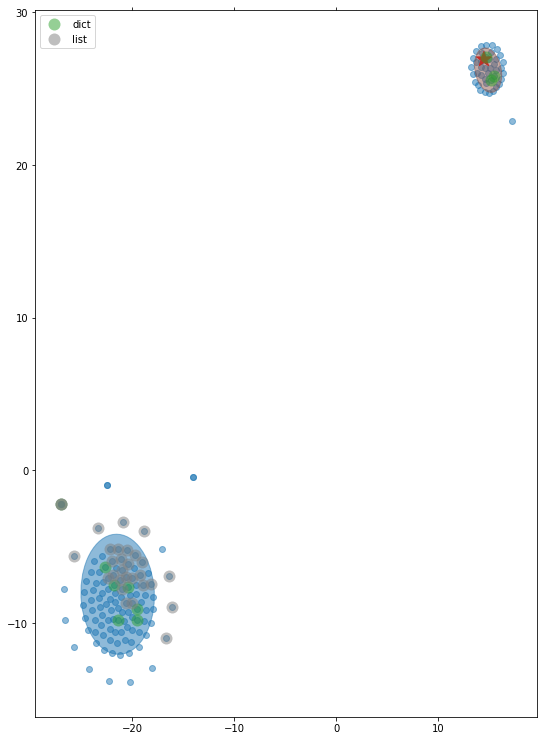

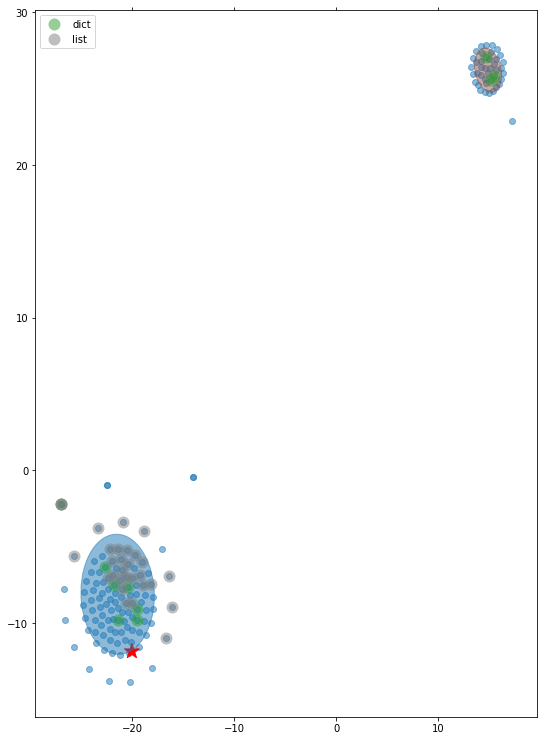

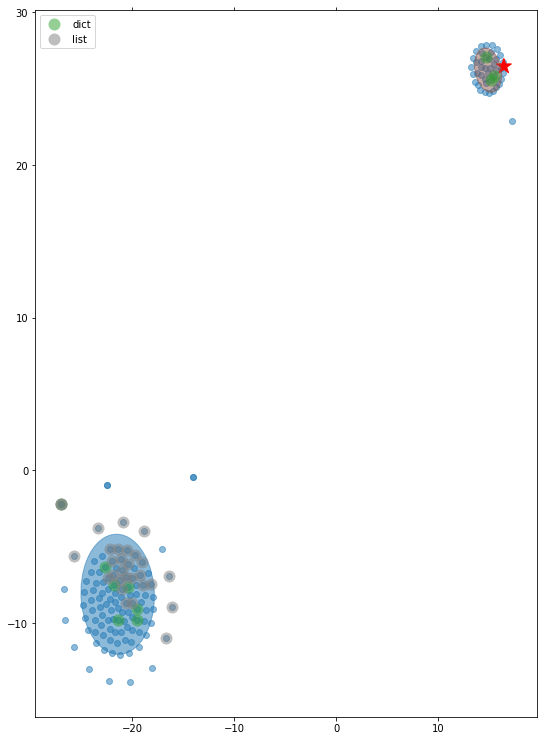

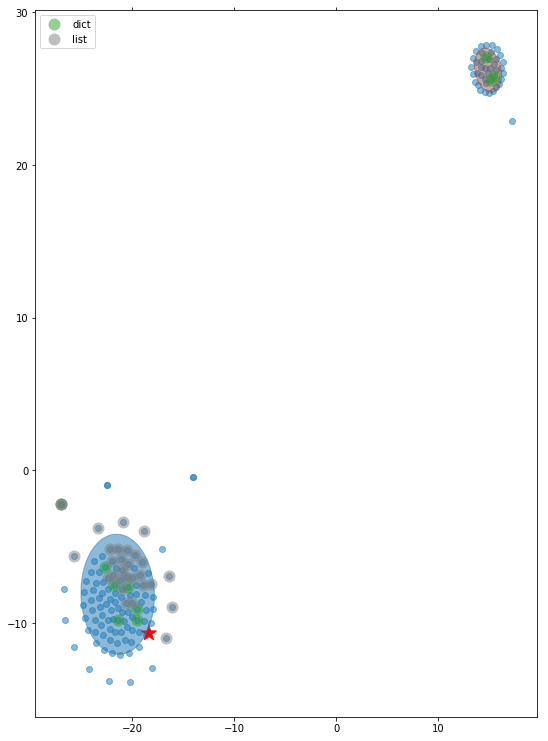

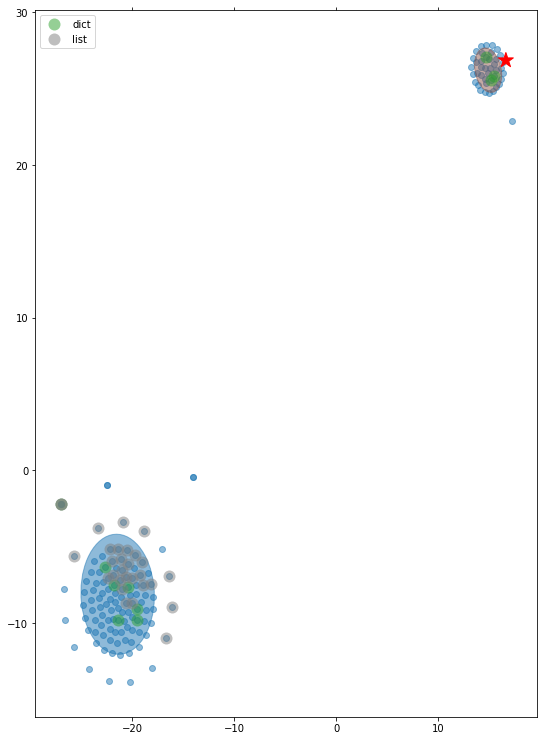

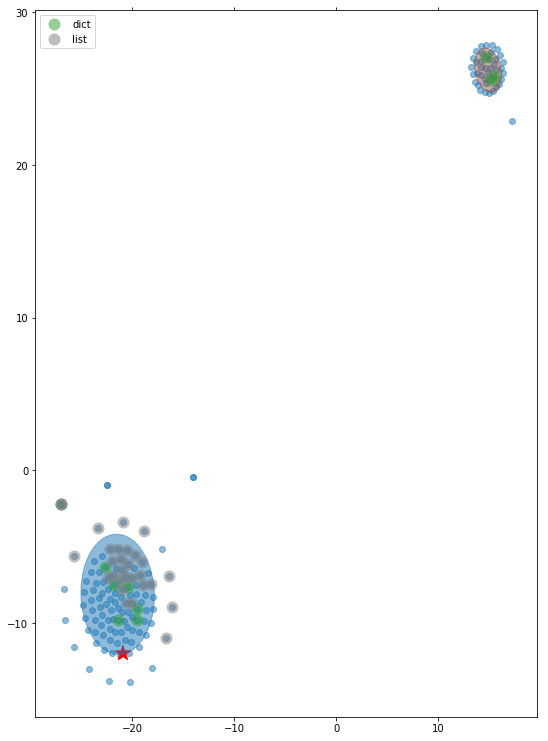

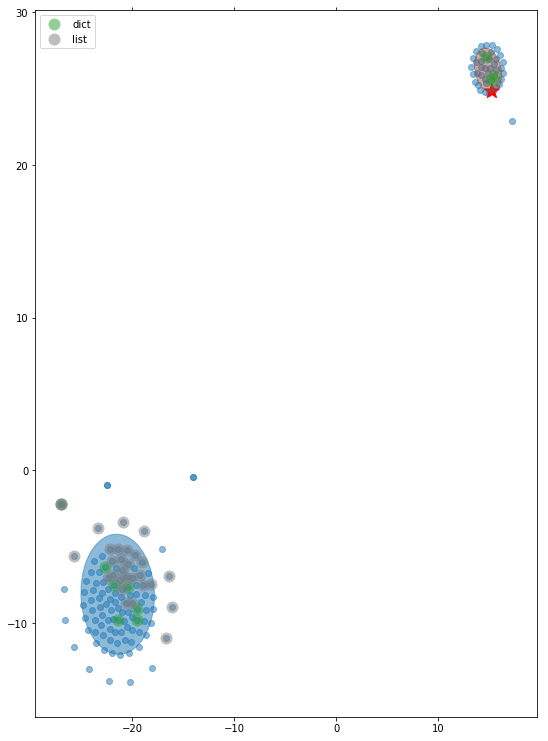

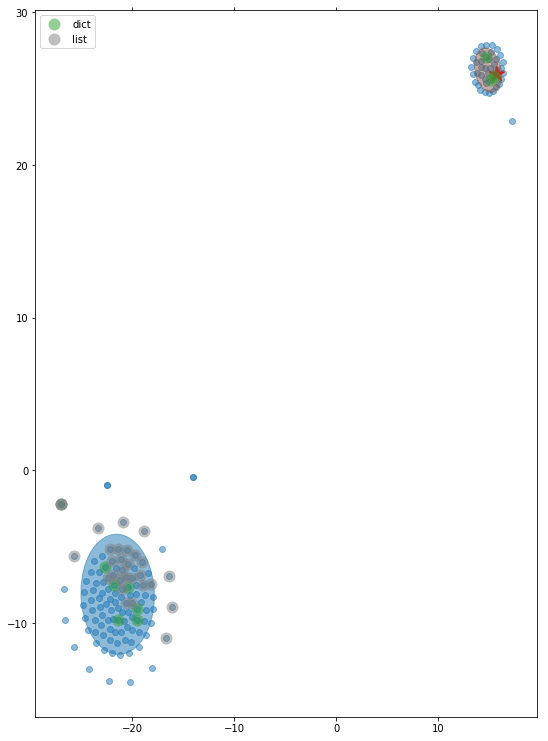

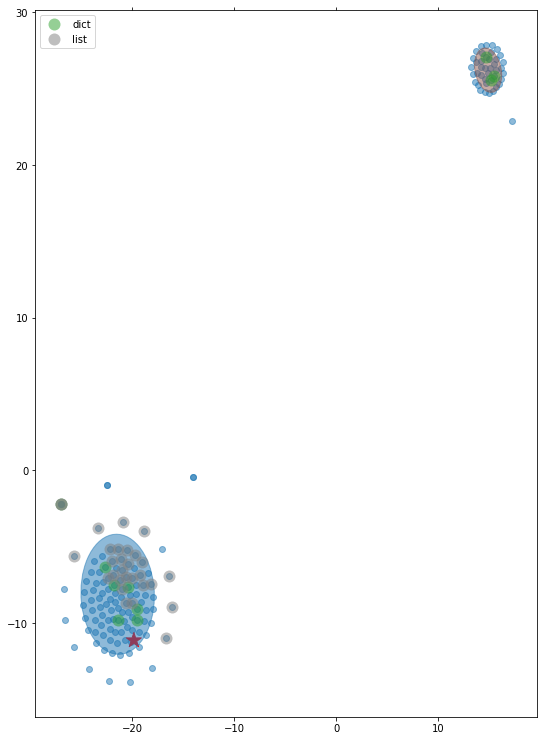

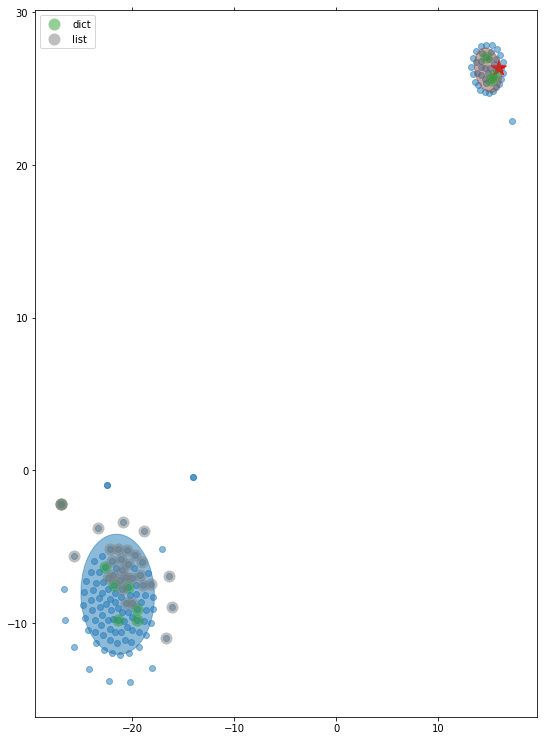

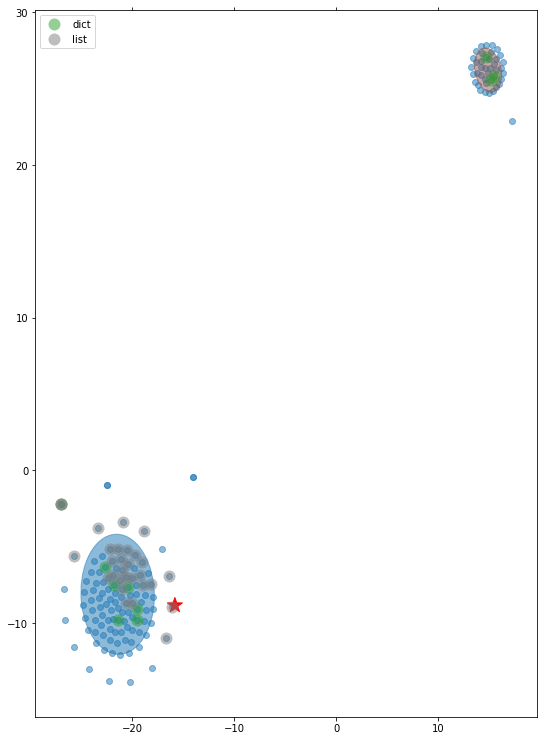

In [16]:
doc = PDFReport()
for i in range(25):
    # Plot sample
    sample_id = get_next_sample(X, Y, W, L)
    
    ellipses_opt = {"gmm": clustering.model, "clusters": clustering.k}
    handler.plot(show_clusters=True, highlight=sample_id, show=False, savefig="solution_%d.png" % sample_id,
                make_ellipses=ellipses_opt)
    print("Question %d" % sample_id)
    
    # Print question
    problem = questions[sample_id]
    solution = solutions[sample_id]
    
    # Suppose that the student gets it correctly
    # Update X matrix
    X[sample_id] = Y[sample_id]
    L.append(sample_id)
    doc.append_solution(sample_id, problem, solution)

doc.generate_pdf("user_trajectory_less_problems")

### References
[1] Johns, E., Aodha, O. Mac & Brostow, G. J. Becoming the expert - Interactive multi-class machine teaching. in Proceedings of the IEEE Computer Society Conference on Computer Vision and Pattern Recognition (2015). doi:10.1109/CVPR.2015.7298877

[2] Zhu, X., Lafferty, J. & Ghahramani, Z. Combining Active Learning and Semi-Supervised Learning Using Gaussian Fields and Harmonic Functions Xiaojin. … Data Mach. Learn. … (2003).